In [1]:
import tweepy
import numpy as np
import preprocessor as p
import csv
import re
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from TwToken import consumer_key, consumer_secret, access_token, access_secret

In [2]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [3]:
SearchQuery = "Twitter" #Keyword to search
def get_dataset():
    print("Mining tweets...")
    mined_tweets = []
    for tweet in tweepy.Cursor(api.search,
                               q=SearchQuery + " -filter:retweets",
                               tweet_mode="extended",
                               lang="en").items(5000):
        mined_tweets.append(tweet.full_text)
    print("Mined tweets : {}".format(len(mined_tweets)))
    return mined_tweets

In [4]:
def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [5]:
def tokenize(tweet):
    token_list = []
    token_list = word_tokenize(tweet)
    token_list = [token for token in token_list if token not in string.punctuation]
    stop_words = set(stopwords.words('english'))
    stop_words.discard('not')
    token_list = [token for token in token_list if not token in stop_words]
    token_list = [token for token in token_list if token.isalpha()]
    return token_list

In [6]:
def stem_tokens(tokens, stemmer):
    token_list = []
    for token in tokens:
        token_list.append(stemmer.stem(token))
    return token_list

In [7]:
def process_tweets(tweet):
    tweet = re.sub(r'[,\.!?]', "", tweet)
    tweet = tweet.lower()
    tweet = decontracted(tweet)
    tweet = p.clean(tweet)
    tokens = tokenize(tweet)
    snowball_stemmer = SnowballStemmer('english')
    stem = stem_tokens(tokens, snowball_stemmer)
    return stem

In [8]:
def fit_tfidf(corpus):
    tf_vect = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x)
    tf_vect.fit(corpus)
    return tf_vect
def fit_lr(X_train, y_train):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    return model

df = pd.read_csv("tweet_data.csv")
df["tokens"] = df["tweet_text"].apply(process_tweets)
df["tweet_sentiment"] = df["sentiment"].apply(lambda i: 1 if i == "positive" else 0)
X = df["tokens"].tolist()
y = df["tweet_sentiment"].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.80)

tf = fit_tfidf(X_train)
X_train_tf = tf.transform(X_train)
X_test_tf = tf.transform(X_test)

model_lr_tf = fit_lr(X_train_tf, y_train)

positive_tweets = []
counterPos = []
counterNeg = []
negative_tweets = []

c:\users\tunao\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [12]:
def plot_frames():                  # plot func
    tweetDf = pd.read_csv('Tweets.csv')
    sns.countplot(data=tweetDf,x = 'Sentiment', palette='hls')
    plt.show()

Mining tweets...
Mined tweets : 500
<bound method NDFrame.tail of                                                 Tweets Sentiment
0    [love, wake, good, bts, news, not, instagram, ...  Positive
1    [shop, best, offer, famous, sweatshirtit, beau...  Positive
2    [seven, beauti, amaz, extraordinari, boy, happ...  Positive
3                                               [love]  Positive
4      [kim, taehyung, share, video, instagram, stori]  Positive
..                                                 ...       ...
995                            [dont, shytak, control]  Negative
996                                             [armi]  Negative
997          [not, wake, bts, ig, alreadi, damn, time]  Negative
998  [mani, thought, fake, first, look, proeditcaus...  Negative
999  [hobi, tae, aesthet, account, yoongi, minimali...  Negative

[1000 rows x 2 columns]>
Positive tweets : 496
Negative tweets : 504


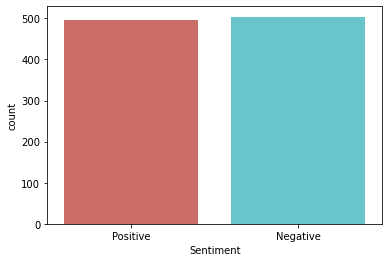

In [13]:
def predict_tweet(tweet):
    processed_tweet = process_tweets(tweet)
    transformed_tweet = tf.transform([processed_tweet])
    prediction = model_lr_tf.predict(transformed_tweet)

    if prediction == 1:
        positive_tweets.append(processed_tweet)


    else:
        negative_tweets.append(processed_tweet)

def main():
    tweets = get_dataset()
    for tweet in tweets:
        predict_tweet(tweet)

    counterPos = ['Positive'] * len(positive_tweets)
    counterNeg = ['Negative'] * len(negative_tweets)

    positiveZipped = list(zip(positive_tweets,counterPos))  # tags tweets positive or negative
    negativeZipped = list(zip(negative_tweets, counterNeg))

    finalList = positiveZipped + negativeZipped  # concatenate

    tweetDf = pd.DataFrame(finalList,columns=['Tweets', 'Sentiment']) #new csv
    tweetDf.to_csv('Tweets.csv')
    print(tweetDf.tail)

    print("Positive tweets : {}".format(len(positive_tweets)))

    print("Negative tweets : {}".format(len(negative_tweets)))
    plot_frames()

if __name__ == "__main__":
    main()
